# Learning to Train with the New SPK
A few APIs have changed for the better

In [2]:
%matplotlib inline 
from matplotlib import pyplot as plt
from fff.learning.gc.functions import GCSchNetForcefield
from ase.db import connect
from random import shuffle
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import shutil
import torch

/home/lward/miniconda3/envs/fastforce/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create the Data Loader
We'll connect to the dataset I made via an external script and use the "same data" 

Load in the initial training set and filtering only a single method

In [3]:
with connect('../initial-database/initial-psi4.db') as db:
    all_strcs = [a.toatoms() for a in db.select(basis='aug-cc-pvdz', method='pbe0-d3')]
shuffle(all_strcs)
print(f'Loaded {len(all_strcs)} structures')

Loaded 1720 structures


Save the first 10% as validation

In [4]:
cut = len(all_strcs) // 10

Save it to a database that contains only the structures we used for training

In [5]:
with connect('initial-database.db', append=False) as db:
    for atoms in all_strcs:
        db.write(atoms)

## Load the Model
Get the model with the updated means

In [5]:
model = torch.load('starting-psi4-model', map_location='cuda')
model.mean

-692.714663566966

## Get the pre-training performance
See how well we do without any modifications

In [6]:
interface = GCSchNetForcefield()

In [7]:
%%time
energy, forces = interface.evaluate(model, all_strcs, device='cuda')

Processing...
Done!
/home/lward/miniconda3/envs/fastforce/lib/python3.10/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


CPU times: user 2.37 s, sys: 200 ms, total: 2.57 s
Wall time: 2.6 s


Plot the performance

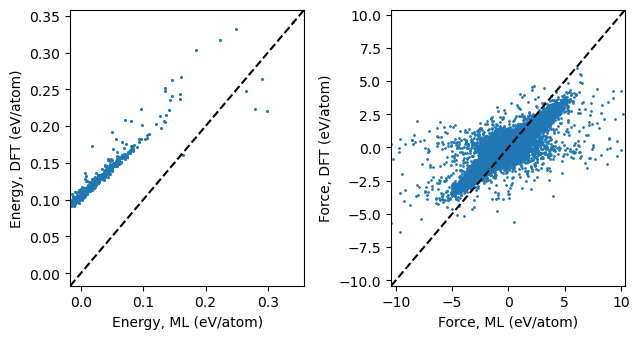

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.5))

# Plot the energies
ax = axs[0]
n_atoms = [len(a) for a in all_strcs]
dft_energies = np.array([a.get_potential_energy() / len(a) for a in all_strcs])
ax.scatter(np.divide(energy, n_atoms) - dft_energies.min(), dft_energies - dft_energies.min(), s=1.5)

ax.set_xlabel('Energy, ML (eV/atom)')
ax.set_ylabel('Energy, DFT (eV/atom)')

# Plot the forces
ax = axs[1]
dft_forces = np.vstack([a.get_forces() for a in all_strcs]).flatten()
ml_forces = np.vstack(forces).flatten()
ax.scatter(ml_forces, dft_forces, s=1)

ax.set_xlabel('Force, ML (eV/atom)')
ax.set_ylabel('Force, DFT (eV/atom)')

for ax in axs:
    ax.set_ylim(ax.get_ylim())
    ax.set_xlim(ax.get_ylim())

    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

fig.tight_layout()

## Run the Training
Just do the 

In [9]:
%%time
model, log = interface.train(model, all_strcs[cut:], all_strcs[:cut], num_epochs=128, device='cuda')

Processing...
Done!
Processing...
Done!


CPU times: user 2min 5s, sys: 197 ms, total: 2min 5s
Wall time: 2min 5s


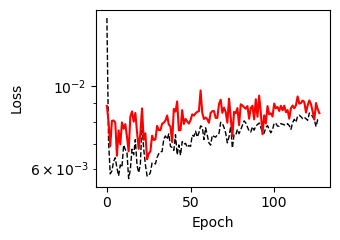

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(log['epoch'], log['train_loss_total'], '--', color='k', lw=1, label='Train')
ax.plot(log['epoch'], log['valid_loss_total'], '-', color='r', label='Validation')

ax.set_yscale('log')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
fig.tight_layout()

## Repeat analysis after training
See how good we are

In [11]:
%%time
energy, forces = interface.evaluate(model, all_strcs, device='cuda')

Processing...
Done!
/home/lward/miniconda3/envs/fastforce/lib/python3.10/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


CPU times: user 2.02 s, sys: 60 ms, total: 2.08 s
Wall time: 2.09 s


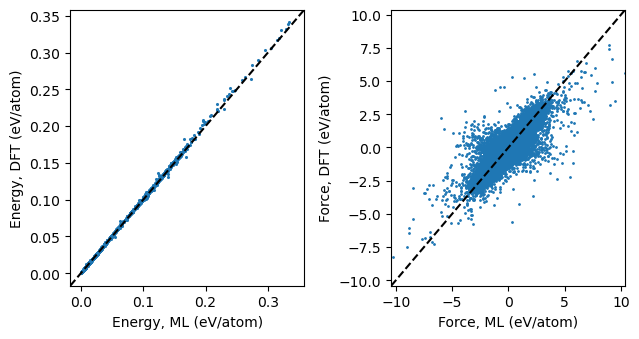

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.5))

# Plot the energies
ax = axs[0]
n_atoms = [len(a) for a in all_strcs]
dft_energies = np.array([a.get_potential_energy() / len(a) for a in all_strcs])
ax.scatter(np.divide(energy, n_atoms) - dft_energies.min(), dft_energies - dft_energies.min(), s=1.5)

ax.set_xlabel('Energy, ML (eV/atom)')
ax.set_ylabel('Energy, DFT (eV/atom)')

# Plot the forces
ax = axs[1]
dft_forces = np.vstack([a.get_forces() for a in all_strcs]).flatten()
ml_forces = np.vstack(forces).flatten()
ax.scatter(ml_forces, dft_forces, s=1)

ax.set_xlabel('Force, ML (eV/atom)')
ax.set_ylabel('Force, DFT (eV/atom)')

for ax in axs:
    ax.set_ylim(ax.get_ylim())
    ax.set_xlim(ax.get_ylim())

    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

fig.tight_layout()

## Save the results
For use later

In [13]:
result_dir = Path('tuned')
if result_dir.is_dir():
    shutil.rmtree(result_dir)
result_dir.mkdir()

In [14]:
torch.save(model, result_dir / 'model')

In [15]:
log.to_csv(result_dir / 'log.csv', index=False)